# GPU Assignment 2 - Interpolation Revisited
*Maha Usmani mu06905*





# Nearest Neighbor CPU COde

CPU and GPU implementations of nearest neighbour interpolation are given below. Shared memory is also used and the time taken by all three proccesses are given as code output.We can see tha nni introduces errors in the code as it creates no new data but simply maps the values of the input image to output image.

In [7]:
!apt-get install gcc

Reading package lists... Done
Building dependency tree       
Reading state information... Done
gcc is already the newest version (4:9.3.0-1ubuntu2).
gcc set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 22 not upgraded.


In [8]:
%%writefile main.c
#include	<math.h>
#include	<stdlib.h>
#include	<stdio.h>
#include	<string.h>
#include	<stddef.h>
#include	<float.h>
#include    <time.h>

#define Width 256
#define Height 256
#define Size Width * Height
#define SizeInBytes Size * sizeof(unsigned char)

void load_image(char * fname, char * inputImage){
    FILE* fp = fopen(fname, "rb");
    if (fp)
    {
        fread(inputImage, 1, 256 * 256, fp);
        fclose(fp);
        
    }
    else
    {
        puts("Cannot open raw image.");
    }
}

void save_image(char* fname, char* outputImage){
    FILE* fp = fopen(fname, "wb");
    printf("%s",fname);

    if (fp)
    {
        fwrite(outputImage, sizeof(unsigned char), 256 * 256, fp);
        
        fclose(fp);
    }

    else
    {
        puts("Cannot write raw image.");
    }
}
void rotateNearestNeighbor(char* input, char* output, float theta){
    for(int i = 0; i<Height;i++){
        for(int j = 0;j<Width;j++){
                float a11 = cos(theta);
                float a21 = sin(theta);
                float a12 = -sin(theta);
                float a22 = cos(theta);
                int img_x = round(a11 * (j - Width/2) + a21*(i - Height/2) + Width/2);
                int img_y = round(a12 * (j - Width/2) + a22 * (i - Height/2) + Height/2);

                if (img_x >= 0 && img_x < Width && img_y >= 0 && img_y < Height) {
                    output[ i * Width + j] = input[img_y * Width + img_x];
                }
                else{
                    output[i * Width + j] = 0;
                }
        }
    }
}
int main(int argc, char** argv){
    
    unsigned char* inputImage = (unsigned char*)malloc(SizeInBytes );
    unsigned char* outputImage = (unsigned char*)malloc(SizeInBytes );
    
    float theta = 24.0f * 3.14159265f / 180.0f;  
    load_image("/content/lena.img", inputImage);
    clock_t start = clock();
    for(int i = 0;i<15;i++){
        rotateNearestNeighbor(inputImage, outputImage, theta);
        memcpy(inputImage, outputImage, SizeInBytes);
    }
    clock_t end = clock();
    double time_taken = ((double)(end - start)) / CLOCKS_PER_SEC;
    printf("rotateNearestNeighbor() took %f seconds to execute \n", time_taken);

    save_image("/content/output.img", outputImage);
         
    return 0;
}

Writing main.c


In [9]:
! gcc main.c -o main2.o -lm
! ./main2.o

rotateNearestNeighbor() took 0.100548 seconds to execute 
/content/output.img

Shape: (65536,)
Size: 65536


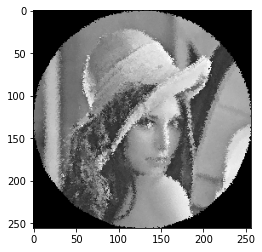

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Parameters.
input_filename = "/content/output.img"
shape = (256,256) # matrix size
dtype = np.dtype(np.uint8) # big-endian unsigned integer (16bit)

# Reading.
fid = open(input_filename, 'rb')
data = np.fromfile(fid, dtype)
print("Shape:", data.shape)
print("Size:", data.size)
image = data.reshape(shape)
# Display.
plt.imshow(image, cmap = "gray")
plt.show()


# Nearest Neighbor GPU Code


In [11]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git
# %load_ext nvcc_plugin
%reload_ext nvcc_plugin

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-tt43upbz
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-tt43upbz
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit aac710a35f52bb78ab34d2e52517237941399eff
  Preparing metadata (setup.py) ... done
directory /content/src already exists
Out bin /content/result.out


In [12]:
%%cu
#include <stdio.h>
#include <cuda.h>


#define BLOCK_SIZE 16
#define Width 256
#define Height 256
#define Size Width * Height
#define SizeInBytes Size * sizeof(unsigned char)

inline cudaError_t checkCudaErr(cudaError_t err, const char* msg) 
{
  if (err != cudaSuccess) 
  {
    fprintf(stderr, "CUDA Runtime error at %s: %s\n", msg, cudaGetErrorString(err));
  }
  return err;
}

void load_image(char * fname, unsigned char * inputImage){
    FILE* fp = fopen(fname, "rb");
    if (fp)
    {
        fread(inputImage, 1, Size, fp);
        fclose(fp);
        
    }
    else
    {
        puts("Cannot open raw image.");
    }
}

void save_image(char* fname, unsigned char* outputImage){
    FILE* fp = fopen(fname, "wb");
    if (fp)
    {
        fwrite(outputImage, sizeof(unsigned char), Size, fp);
        
        fclose(fp);
    }

    else
    {
        puts("Cannot write raw image.");
    }
}

__global__ void rotateImageNearestNeighbor(unsigned char* input, unsigned char* output, float theta) {
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    if (x < Width && y < Height) {

        float a11 = cos(theta);
        float a21 = sin(theta);
        float a12 = -sin(theta);
        float a22 = cos(theta);
        int img_x = round(a11 * (y - Width/2) + a21*(x - Height/2) + Width/2);
        int img_y = round(a12 * (y - Width/2) + a22 * (x - Height/2) + Height/2);

        if (img_x >= 0 && img_x < Width && img_y >= 0 && img_y < Height) {
            output[ x * Width + y] = input[img_y * Width + img_x];
        }
        else{
            output[x * Width + y] = 0;
        }
    }
}

__global__ void rotateImageNearestNeighborShared(unsigned char* input, unsigned char* output, float theta) {
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;
    int tx = threadIdx.x;
    int ty = threadIdx.y;

    __shared__ unsigned char sharedInput[BLOCK_SIZE][BLOCK_SIZE];

    // Load input image data into shared memory
    if (tx < Width && ty < Height) {
        float a11 = cos(theta);
        float a21 = sin(theta);
        float a12 = -sin(theta);
        float a22 = cos(theta);
        int img_x = round(a11 * (ty - Width/2) + a21*(tx - Height/2) + Width/2);
        int img_y = round(a12 * (ty - Width/2) + a22 * (tx - Height/2) + Height/2);

        if (img_x >= 0 && img_x < Width && img_y >= 0 && img_y < Height) {
            sharedInput[tx][ty] = input[img_y * Width + img_x];
        }
        else {
            sharedInput[tx][ty] = 0;
        }
    }

    __syncthreads();

    // Rotate image using shared memory
    if (x < Width && y < Height) {
        output[x * Width + y] = sharedInput[ty][tx];
    }
}



int main() {

    float theta = 24.0f * 3.14159265f / 180.0f;  
    
    unsigned char* inputImage = (unsigned char*)malloc(SizeInBytes);
    unsigned char* outputImage = (unsigned char*)malloc(SizeInBytes );
    unsigned char* outputImage_shared = (unsigned char*)malloc(SizeInBytes );
    unsigned char* d_inputImage;
    unsigned char* d_inputImage_shared;
    unsigned char* d_outputImage;
    unsigned char* d_outputImage_shared;

    cudaMalloc(&d_inputImage ,SizeInBytes );
    cudaMalloc(&d_inputImage_shared ,SizeInBytes );
    cudaMalloc(&d_outputImage, SizeInBytes);
    cudaMalloc(&d_outputImage_shared, SizeInBytes);
    
    load_image("/content/lena.img", inputImage);
    cudaMemcpy(d_inputImage, inputImage, SizeInBytes, cudaMemcpyHostToDevice);
    cudaMemcpy(d_inputImage_shared, inputImage, SizeInBytes, cudaMemcpyHostToDevice);

    dim3 blockSize(16, 16);
    dim3 gridSize(16,16);

    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);

    // First loop: without shared memory
    cudaEventRecord(start);
    for(int i = 0;i< 15;i++){
        rotateImageNearestNeighbor << <gridSize, blockSize >> > (d_inputImage, d_outputImage, theta);
        cudaMemcpy(d_inputImage, d_outputImage, SizeInBytes, cudaMemcpyDeviceToDevice);
    }
    cudaEventRecord(stop);
    cudaEventSynchronize(stop);

    float milliseconds = 0;
    cudaEventElapsedTime(&milliseconds, start, stop);
    printf("Time elapsed without shared memory: %f ms\n", milliseconds);
    cudaMemcpy(outputImage, d_outputImage, SizeInBytes, cudaMemcpyDeviceToHost);
    save_image("/content/output.img", outputImage);

   

    // Second loop: with shared memory
    cudaEventRecord(start);
    for(int i = 0;i< 15;i++){
        rotateImageNearestNeighborShared << <gridSize, blockSize >> > (d_inputImage_shared, d_outputImage_shared, theta);
        cudaMemcpy(d_inputImage_shared, d_outputImage_shared, SizeInBytes, cudaMemcpyDeviceToDevice);
    }
    cudaEventRecord(stop);
    cudaEventSynchronize(stop);

    milliseconds = 0;
    cudaEventElapsedTime(&milliseconds, start, stop);
    printf("Time elapsed with shared memory: %f ms\n", milliseconds);
    cudaEventRecord(stop);
    cudaEventSynchronize(stop);

    
    

    cudaMemcpy(outputImage_shared, d_outputImage_shared, SizeInBytes, cudaMemcpyDeviceToHost);
    save_image("/content/output_shared.img", outputImage);

    

    free(inputImage);
    free(outputImage);
    cudaFree(d_inputImage);
    cudaFree(d_outputImage);
    return 0;
}


Time elapsed without shared memory: 0.237920 ms
Time elapsed with shared memory: 0.217760 ms



Shape: (65536,)
Size: 65536


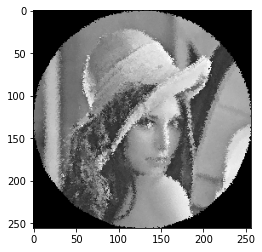

Shape: (65536,)
Size: 65536


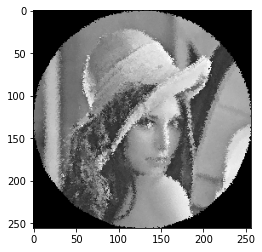

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Parameters.
input_filename = "/content/output.img"
shape = (256,256) # matrix size
dtype = np.dtype(np.uint8) # big-endian unsigned integer (16bit)

# Reading.
fid = open(input_filename, 'rb')
data = np.fromfile(fid, dtype)
print("Shape:", data.shape)
print("Size:", data.size)
image = data.reshape(shape)
# Display.
plt.imshow(image, cmap = "gray")
plt.show()

# Parameters.
input_filename = "/content/output_shared.img"
shape = (256,256) # matrix size
dtype = np.dtype(np.uint8) # big-endian unsigned integer (16bit)

# Reading.
fid = open(input_filename, 'rb')
data = np.fromfile(fid, dtype)
print("Shape:", data.shape)
print("Size:", data.size)
image = data.reshape(shape)
# Display.
plt.imshow(image, cmap = "gray")
plt.show()


# BICUBIC CPU CODE

We can observe here that cublic spline method significantly reduces the error in the image . cpu and gpu implementations of the code are given below. Time taken by both implementations are also given as output of the cell.

In [14]:
%%writefile bicubic2.c
//reference https://www.paulinternet.nl/?page=bicubic
#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <string.h>
#include <time.h>

#define PI 3.14159265358979323846
#define Width 256
#define Height 256
#define Size Width * Height
#define SizeInBytes Size * sizeof(unsigned char)

void load_image(char * fname, unsigned char * inputImage){
    FILE* fp = fopen(fname, "rb");
    if (fp)
    {
        fread(inputImage, 1, Size, fp);
        fclose(fp);
        
    }
    else
    {
        puts("Cannot open raw image.");
    }
}

void save_image(char* fname, unsigned char* outputImage){
    FILE* fp = fopen(fname, "wb");
    if (fp)
    {
        fwrite(outputImage, sizeof(unsigned char), Size, fp);
        
        fclose(fp);
    }

    else
    {
        puts("Cannot write raw image.");
    }
}

double cubicInterpolate(double *c, double x) {
    return  c[1] + 0.5 * x * (c[2] - c[0] + x * (2.0 * c[0] - 5.0 * c[1] + 4.0 * c[2] - c[3] + x * (3.0 * (c[1] - c[2]) + c[3] - c[0])));
}

double bicubicInterpolate(double p[4][4], double x, double y) {
   
    double arr[4];
    arr[0] = cubicInterpolate(p[0], x);
    arr[1] = cubicInterpolate(p[1], x);
    arr[2] = cubicInterpolate(p[2], x);
    arr[3] = cubicInterpolate(p[3], x);
    return cubicInterpolate(arr, y);
}

void rotate(unsigned char *inputImage, unsigned char *outputImage){
    double theta = 24 * PI / 180;

    for(int i=0; i<Height; i++) {
        for(int j=0; j<Width; j++) {
            float a11 = cos(theta);
            float a21 = sin(theta);
            float a12 = -sin(theta);
            float a22 = cos(theta);
            float x = (a11 * (j - Width/2) + a21*(i - Height/2) + Width/2);
            float y = (a12 * (j - Width/2) + a22 * (i - Height/2) + Height/2);
            if(x >= 0 && x < Width-1 && y >= 0 && y < Height-1) {
                int x0 = (int)floor(x+0.0);
                int y0 = (int)floor(y+0.0);

                double intX = x - x0;
                double intY = y - y0;

                double neighbours[4][4];
                //populate neighbours
                for(int m=0; m<4; m++) {
                    for(int n=0; n<=3; n++) {
                        int xidx = x0 + n - 1;
                        int yidx = y0 + m - 1;
                        if(xidx >= 0 && xidx < Width && yidx >= 0 && yidx < Height) {
                            neighbours[m][n] = inputImage[yidx*Width+xidx];
                        } else {
                            neighbours[m][n] = 0;
                        }
                    }
                }
                float interpolated = bicubicInterpolate(neighbours, intX, intY);
                if (interpolated>255 || interpolated<0){
                    interpolated = 0;
                }
                outputImage[i*Width+j] = (unsigned char) round(interpolated);
            }
            else{
                outputImage[i*Width+j] = 0;
                
            }
        }
    }
}



int main() {
    unsigned char* inputImage = (unsigned char*)malloc(SizeInBytes);
    unsigned char* outputImage = (unsigned char*)malloc(SizeInBytes);

    load_image("/content/lena.img",inputImage);

    clock_t start = clock();
    for (int i = 0; i<15;i++){
        rotate(inputImage,outputImage);
        memcpy(inputImage,outputImage,SizeInBytes);
    }
    clock_t end = clock();
    double time_spent = (double)(end - start) / CLOCKS_PER_SEC;
    printf("Time taken: %f seconds\n", time_spent);

    save_image("/content/output.img",outputImage);

    return 0;
}



Writing bicubic2.c


In [15]:
! gcc bicubic2.c -o bicubic2.o -lm
! ./bicubic2.o

Time taken: 0.258166 seconds


Shape: (65536,)
Size: 65536


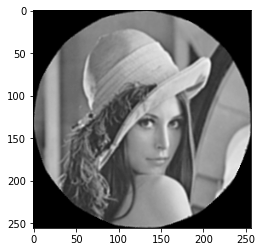

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Parameters.
input_filename = "output.img"
shape = (256,256) # matrix size
dtype = np.dtype(np.uint8) # big-endian unsigned integer (16bit)

# Reading.
fid = open(input_filename, 'rb')
data = np.fromfile(fid, dtype)
print("Shape:", data.shape)
print("Size:", data.size)
image = data.reshape(shape)
# Display.
plt.imshow(image, cmap = "gray")
plt.show()



# BICUBIC GPU CODE


In [ ]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git
# %load_ext nvcc_plugin
%reload_ext nvcc_plugin

In [18]:
%%cu
#include <stdio.h>
#include <cuda.h>


#define BLOCK_SIZE 16
#define Width 256
#define Height 256
#define Size Width * Height
#define SizeInBytes Size * sizeof(unsigned char)
#define PI  3.14159265f

inline cudaError_t checkCudaErr(cudaError_t err, const char* msg) {
  if (err != cudaSuccess) 
  {
    fprintf(stderr, "CUDA Runtime error at %s: %s\n", msg, cudaGetErrorString(err));
  }
  return err;
}
void load_image(char * fname, unsigned char * inputImage){
    FILE* fp = fopen(fname, "rb");
    if (fp)
    {
        fread(inputImage, 1, Size, fp);
        fclose(fp);
        
    }
    else
    {
        puts("Cannot open raw image.");
    }
}

void save_image(char* fname, unsigned char* outputImage){
    FILE* fp = fopen(fname, "wb");
    if (fp)
    {
        fwrite(outputImage, sizeof(unsigned char), Size, fp);
        
        fclose(fp);
    }

    else
    {
        puts("Cannot write raw image.");
    }
}

__device__ float cubicInterpolate(double c[4], double x) {
    return c[1] + 0.5 * x * (c[2] - c[0] + x * (2.0 * c[0] - 5.0 * c[1] + 4.0 * c[2] - c[3] + x * (3.0 * (c[1] - c[2]) + c[3] - c[0])));
}

__device__ float bicubicInterpolate(double p[4][4], double x, double y) {
    double arr[4];
    arr[0] = cubicInterpolate(p[0], x);
    arr[1] = cubicInterpolate(p[1], x);
    arr[2] = cubicInterpolate(p[2], x);
    arr[3] = cubicInterpolate(p[3], x);
    return cubicInterpolate(arr, y);
}

__global__ void rotate(unsigned char *inputImage, unsigned char *outputImage, int width, int height) {
    double theta = 24 * PI / 180;
    int j = threadIdx.x + blockIdx.x * blockDim.x;
    int i = threadIdx.y + blockIdx.y * blockDim.y;

    if(i < height && j < width) {
        float a11 = cos(theta);
        float a21 = sin(theta);
        float a12 = -sin(theta);
        float a22 = cos(theta);
        float x = (a11 * (j - Width/2) + a21*(i - Height/2) + Width/2);
        float y = (a12 * (j - Width/2) + a22 * (i - Height/2) + Height/2);
        if(x >= 0 && x < width-1 && y >= 0 && y < height-1) {
            int x0 = (int)floor(x+0.0);
            int y0 = (int)floor(y+0.0);

            double intX = x - x0;
            double intY = y - y0;

            double neighbours[4][4];
            //populate neighbours
            for(int m=0; m<=3; m++) {
                for(int n=0; n<=3; n++) {
                    int xidx = x0 + n - 1;
                    int yidx = y0 + m - 1;
                    if(xidx >= 0 && xidx < Width && yidx >= 0 && yidx < Height) {
                        neighbours[m][n] = inputImage[yidx*Width+xidx];
                    } else {
                        neighburs[m][n] = 0;
                    }
                }
            }
            float interpolated = bicubicInterpolate(neighbours, intX, intY);
            if (interpolated>255 || interpolated<0){
                interpolated = 0;
            }
            outputImage[i*width+j] = (unsigned char) round(interpolated);
        }
        else{
            outputImage[i*width+j] = 0;
            
        }
    }
}


int main() {

    float theta = 10.0f * 3.14159265f / 180.0f;  
    
    unsigned char* inputImage = (unsigned char*)malloc(SizeInBytes);
    unsigned char* outputImage = (unsigned char*)malloc(SizeInBytes );
    unsigned char* d_inputImage;
    unsigned char* d_outputImage;

    checkCudaErr(cudaMalloc(&d_inputImage ,SizeInBytes ),"malloc1");
    checkCudaErr(cudaMalloc(&d_outputImage, SizeInBytes),"malloc2");
    
    load_image("/content/lena.img", inputImage);
    checkCudaErr(cudaMemcpy(d_inputImage, inputImage, SizeInBytes, cudaMemcpyHostToDevice),"memcpy1");

    dim3 blockSize(16, 16);
    dim3 gridSize(16,16);

    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);

    cudaEventRecord(start);
    for(int i = 0;i< 15;i++){
        rotate <<<gridSize, blockSize >>> (d_inputImage, d_outputImage,256,256);
        checkCudaErr(cudaMemcpy(d_inputImage, d_outputImage, SizeInBytes, cudaMemcpyDeviceToDevice),"memcpy2");
    }
    cudaEventRecord(stop);
    cudaEventSynchronize(stop);

    float milliseconds = 0;
    cudaEventElapsedTime(&milliseconds, start, stop);
    printf("Time elapsed: %f ms\n", milliseconds);
    checkCudaErr(cudaMemcpy(outputImage, d_outputImage, SizeInBytes, cudaMemcpyDeviceToHost),"memcpy3");
    save_image("/content/output.img", outputImage);





    free(inputImage);
    free(outputImage);
    cudaFree(d_inputImage);
    cudaFree(d_outputImage);
    return 0;
}

Time elapsed: 2.158592 ms



Shape: (65536,)
Size: 65536


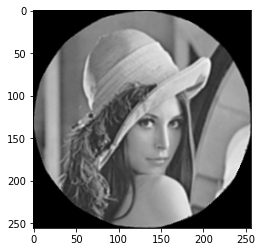

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Parameters.
input_filename = "output.img"
shape = (256,256) # matrix size
dtype = np.dtype(np.uint8) # big-endian unsigned integer (16bit)

# Reading.
fid = open(input_filename, 'rb')
data = np.fromfile(fid, dtype)
print("Shape:", data.shape)
print("Size:", data.size)
image = data.reshape(shape)
# Display.
plt.imshow(image, cmap = "gray")
plt.show()



References:
https://www.paulinternet.nl/?page=bicubic

https://www.bragitoff.com/2018/02/cubic-spline-piecewise-interpolation-c-program/


